### Imports

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import os
import bbknn
from pathlib import Path

### Single cell settings

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(80)
sc.settings._file_format_figs = 'pdf'
sc.settings.savefigs = False
use_first_n_samples = 0
full_sparse = False

C:\Users\TzachiHNB2\AppData\Local\Temp\ipykernel_17172\3661074169.py:2: FutureWarning: The specified parameters ('scanpy',) are no longer positional. Please specify them like `scanpy=80`
  sc.settings.set_figure_params(80)


### Basic QC workflow

In [3]:
adata_control = sc.read(r'/Code/data/single_cell/animals/turtle/turtle_3/h5ads/painted_turtle/processed/''adata_painted_control.h5ad')
adata_lf = sc.read(r'/Code/data/single_cell/animals/turtle/turtle_3/h5ads/painted_turtle/processed/''adata_painted_lf.h5ad')
adata_lps = sc.read(r'/Code/data/single_cell/animals/turtle/turtle_3/h5ads/painted_turtle/processed/''adata_painted_lps.h5ad')
adata_pic = sc.read(r'/Code/data/single_cell/animals/turtle/turtle_3/h5ads/painted_turtle/processed/''adata_painted_pic.h5ad')

data_names = ['control','lf','lps','pic']
adata = adata_control.concatenate([adata_lf, adata_lps, adata_pic], batch_categories=data_names, batch_key='treatment')

c:\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [4]:
adatas = []

adatas.append(adata_control)
adatas.append(adata_lf)
adatas.append(adata_lps)
adatas.append(adata_pic)

In [5]:
adata.obs

,n_genes_by_counts,total_counts,leiden,treatment
AAACCCAAGATGTAGT-control,218,215.547119,0,control
AAACCCAAGGTCGTAG-control,158,163.719223,4,control
AAACCCACAGCATCTA-control,576,546.419678,1,control
AAACCCATCAGCATTG-control,622,630.827698,5,control
AAACGAAAGGTTGAGC-control,482,492.935730,1,control
...,...,...,...,...
TTTGTTGCACGAAAGC-pic,624,1747.000000,6,pic
TTTGTTGCAGAAGTTA-pic,263,514.000000,2,pic
TTTGTTGCATGAAGGC-pic,133,447.000000,3,pic
TTTGTTGGTATGGAAT-pic,405,1020.000000,1,pic


In [6]:
adata.var

,gene_ids,n_cells_by_counts-control,mean_counts-control,pct_dropout_by_counts-control,total_counts-control,n_cells_by_counts-lf,mean_counts-lf,pct_dropout_by_counts-lf,total_counts-lf,n_cells_by_counts-lps,mean_counts-lps,pct_dropout_by_counts-lps,total_counts-lps,n_cells_by_counts-pic,mean_counts-pic,pct_dropout_by_counts-pic,total_counts-pic
ENSCPBG00000005308.1,ENSCPBG00000005308.1,10,0.001509,99.812101,8.030085,12,0.003970,99.773157,21.0,21,0.002277,99.840583,30.0,20,0.006360,99.646643,36.0
ENSCPBG00000018460.1,ENSCPBG00000018460.1,87,0.014653,98.365276,77.985855,72,0.020227,98.638941,107.0,87,0.008199,99.339558,108.0,47,0.012014,99.169611,68.0
ENSCPBG00000010156.1,ENSCPBG00000010156.1,11,0.001715,99.793311,9.128696,11,0.003025,99.792060,16.0,25,0.002961,99.810218,39.0,8,0.002297,99.858657,13.0
ENSCPBG00000011739.1,ENSCPBG00000011739.1,26,0.005531,99.511462,29.438486,21,0.006805,99.603025,36.0,41,0.004934,99.688757,65.0,5,0.001237,99.911661,7.0
ENSCPBG00000014496.1,ENSCPBG00000014496.1,243,0.042961,95.434047,228.637787,176,0.043667,96.672968,231.0,599,0.072725,95.452820,958.0,118,0.024382,97.915194,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSCPBG00000013786.1,ENSCPBG00000013786.1,20,0.003387,99.624201,18.022957,17,0.004159,99.678639,22.0,24,0.002429,99.817809,32.0,10,0.002473,99.823322,14.0
ENSCPBG00000024548.1,ENSCPBG00000024548.1,0,0.000000,100.000000,0.000000,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0
ENSCPBG00000002099.1,ENSCPBG00000002099.1,99,0.016794,98.139797,89.379837,90,0.029112,98.298677,154.0,172,0.017764,98.694299,234.0,85,0.021908,98.498233,124.0
ENSCPBG00000012984.1,ENSCPBG00000012984.1,0,0.000000,100.000000,0.000000,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0


In [7]:
genes = pd.read_csv('/Code/data/single_cell/animals/turtle/turtle_3/eggnog_croc_chic_komo_turt.csv')
genes.dropna(subset = ['turtle gene id'], inplace=True)

genes_dict = dict(zip(genes['turtle gene id'].astype('str'), genes.eggnog_name.astype('str')))

dict_multi, dict_uni = {}, {}
for d in genes_dict:
    if len(d.split(',')) != 1:
        dict_multi[d] = genes_dict[d]
    else:
        dict_uni[d] =  genes_dict[d]

multi_result_dict = {}

for key_str, value in dict_multi.items():
    # Convert the string key to a set
    key_set = set(key_str.strip("{}").replace("'", "").split(", "))

    # Iterate through the elements in the set and create individual keys
    for element in key_set:
        multi_result_dict[element] = value

genes_dict = {**dict_uni, **multi_result_dict}

genes_dict

{'ENSCPBG00000026464': 'A1CF',
 'ENSCPBG00000025172': 'A4GALT',
 'ENSCPBG00000001788': 'AAAS',
 'ENSCPBG00000024879': 'AACS',
 'ENSCPBG00000018813': 'AADAC',
 'ENSCPBG00000005459': 'AAED1',
 'ENSCPBG00000025560': 'AAGAB',
 'ENSCPBG00000027793': 'AAMDC',
 'ENSCPBG00000013283': 'AAMP',
 'ENSCPBG00000028003': 'AANAT',
 'ENSCPBG00000018203': 'AAR2',
 'ENSCPBG00000002995': 'AARS',
 'ENSCPBG00000025329': 'AARS2',
 'ENSCPBG00000016295': 'AARSD1',
 'ENSCPBG00000025116': 'AASDH',
 'ENSCPBG00000000192': 'AASDHPPT',
 'ENSCPBG00000008417': 'AASS',
 'ENSCPBG00000009608': 'AATF',
 'ENSCPBG00000010476': 'AATK',
 'ENSCPBG00000026638': 'ABAT',
 'ENSCPBG00000020497': 'ABCA1',
 'ENSCPBG00000015417': 'ABCA12',
 'ENSCPBG00000016499': 'ABCA13',
 'ENSCPBG00000010737': 'ABCA2',
 'ENSCPBG00000000183': 'ABCA3',
 'ENSCPBG00000017387': 'ABCA4',
 'ENSCPBG00000010213': 'ABCA5',
 'ENSCPBG00000021237': 'ABCB1',
 'ENSCPBG00000006163': 'ABCB10',
 'ENSCPBG00000006998': 'ABCB11',
 'ENSCPBG00000014879': 'ABCB7',
 'ENSCPBG

In [8]:
adata.var.index = adata.var.index.map(lambda value: value.replace('.1','')) 
adata.var

,gene_ids,n_cells_by_counts-control,mean_counts-control,pct_dropout_by_counts-control,total_counts-control,n_cells_by_counts-lf,mean_counts-lf,pct_dropout_by_counts-lf,total_counts-lf,n_cells_by_counts-lps,mean_counts-lps,pct_dropout_by_counts-lps,total_counts-lps,n_cells_by_counts-pic,mean_counts-pic,pct_dropout_by_counts-pic,total_counts-pic
ENSCPBG00000005308,ENSCPBG00000005308.1,10,0.001509,99.812101,8.030085,12,0.003970,99.773157,21.0,21,0.002277,99.840583,30.0,20,0.006360,99.646643,36.0
ENSCPBG00000018460,ENSCPBG00000018460.1,87,0.014653,98.365276,77.985855,72,0.020227,98.638941,107.0,87,0.008199,99.339558,108.0,47,0.012014,99.169611,68.0
ENSCPBG00000010156,ENSCPBG00000010156.1,11,0.001715,99.793311,9.128696,11,0.003025,99.792060,16.0,25,0.002961,99.810218,39.0,8,0.002297,99.858657,13.0
ENSCPBG00000011739,ENSCPBG00000011739.1,26,0.005531,99.511462,29.438486,21,0.006805,99.603025,36.0,41,0.004934,99.688757,65.0,5,0.001237,99.911661,7.0
ENSCPBG00000014496,ENSCPBG00000014496.1,243,0.042961,95.434047,228.637787,176,0.043667,96.672968,231.0,599,0.072725,95.452820,958.0,118,0.024382,97.915194,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSCPBG00000013786,ENSCPBG00000013786.1,20,0.003387,99.624201,18.022957,17,0.004159,99.678639,22.0,24,0.002429,99.817809,32.0,10,0.002473,99.823322,14.0
ENSCPBG00000024548,ENSCPBG00000024548.1,0,0.000000,100.000000,0.000000,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0
ENSCPBG00000002099,ENSCPBG00000002099.1,99,0.016794,98.139797,89.379837,90,0.029112,98.298677,154.0,172,0.017764,98.694299,234.0,85,0.021908,98.498233,124.0
ENSCPBG00000012984,ENSCPBG00000012984.1,0,0.000000,100.000000,0.000000,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0


In [9]:
adata.var.index = adata.var.index.map(lambda value: genes_dict.get(value, value))
adata.var

,gene_ids,n_cells_by_counts-control,mean_counts-control,pct_dropout_by_counts-control,total_counts-control,n_cells_by_counts-lf,mean_counts-lf,pct_dropout_by_counts-lf,total_counts-lf,n_cells_by_counts-lps,mean_counts-lps,pct_dropout_by_counts-lps,total_counts-lps,n_cells_by_counts-pic,mean_counts-pic,pct_dropout_by_counts-pic,total_counts-pic
TXNDC9,ENSCPBG00000005308.1,10,0.001509,99.812101,8.030085,12,0.003970,99.773157,21.0,21,0.002277,99.840583,30.0,20,0.006360,99.646643,36.0
ECM2,ENSCPBG00000018460.1,87,0.014653,98.365276,77.985855,72,0.020227,98.638941,107.0,87,0.008199,99.339558,108.0,47,0.012014,99.169611,68.0
PIK3AP1,ENSCPBG00000010156.1,11,0.001715,99.793311,9.128696,11,0.003025,99.792060,16.0,25,0.002961,99.810218,39.0,8,0.002297,99.858657,13.0
GM10644,ENSCPBG00000011739.1,26,0.005531,99.511462,29.438486,21,0.006805,99.603025,36.0,41,0.004934,99.688757,65.0,5,0.001237,99.911661,7.0
ENSCPBG00000014496,ENSCPBG00000014496.1,243,0.042961,95.434047,228.637787,176,0.043667,96.672968,231.0,599,0.072725,95.452820,958.0,118,0.024382,97.915194,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PHKG2,ENSCPBG00000013786.1,20,0.003387,99.624201,18.022957,17,0.004159,99.678639,22.0,24,0.002429,99.817809,32.0,10,0.002473,99.823322,14.0
HTR7,ENSCPBG00000024548.1,0,0.000000,100.000000,0.000000,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0
SLC39A14,ENSCPBG00000002099.1,99,0.016794,98.139797,89.379837,90,0.029112,98.298677,154.0,172,0.017764,98.694299,234.0,85,0.021908,98.498233,124.0
GORAB,ENSCPBG00000012984.1,0,0.000000,100.000000,0.000000,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0


In [10]:
adata.var.index.name = 'gene_name'
adata.var

,gene_ids,n_cells_by_counts-control,mean_counts-control,pct_dropout_by_counts-control,total_counts-control,n_cells_by_counts-lf,mean_counts-lf,pct_dropout_by_counts-lf,total_counts-lf,n_cells_by_counts-lps,mean_counts-lps,pct_dropout_by_counts-lps,total_counts-lps,n_cells_by_counts-pic,mean_counts-pic,pct_dropout_by_counts-pic,total_counts-pic
gene_name,,,,,,,,,,,,,,,,,
TXNDC9,ENSCPBG00000005308.1,10,0.001509,99.812101,8.030085,12,0.003970,99.773157,21.0,21,0.002277,99.840583,30.0,20,0.006360,99.646643,36.0
ECM2,ENSCPBG00000018460.1,87,0.014653,98.365276,77.985855,72,0.020227,98.638941,107.0,87,0.008199,99.339558,108.0,47,0.012014,99.169611,68.0
PIK3AP1,ENSCPBG00000010156.1,11,0.001715,99.793311,9.128696,11,0.003025,99.792060,16.0,25,0.002961,99.810218,39.0,8,0.002297,99.858657,13.0
GM10644,ENSCPBG00000011739.1,26,0.005531,99.511462,29.438486,21,0.006805,99.603025,36.0,41,0.004934,99.688757,65.0,5,0.001237,99.911661,7.0
ENSCPBG00000014496,ENSCPBG00000014496.1,243,0.042961,95.434047,228.637787,176,0.043667,96.672968,231.0,599,0.072725,95.452820,958.0,118,0.024382,97.915194,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PHKG2,ENSCPBG00000013786.1,20,0.003387,99.624201,18.022957,17,0.004159,99.678639,22.0,24,0.002429,99.817809,32.0,10,0.002473,99.823322,14.0
HTR7,ENSCPBG00000024548.1,0,0.000000,100.000000,0.000000,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0
SLC39A14,ENSCPBG00000002099.1,99,0.016794,98.139797,89.379837,90,0.029112,98.298677,154.0,172,0.017764,98.694299,234.0,85,0.021908,98.498233,124.0


In [11]:
adata.var['gene_ids']

gene_name
TXNDC9                ENSCPBG00000005308.1
ECM2                  ENSCPBG00000018460.1
PIK3AP1               ENSCPBG00000010156.1
GM10644               ENSCPBG00000011739.1
ENSCPBG00000014496    ENSCPBG00000014496.1
                              ...         
PHKG2                 ENSCPBG00000013786.1
HTR7                  ENSCPBG00000024548.1
SLC39A14              ENSCPBG00000002099.1
GORAB                 ENSCPBG00000012984.1
UBE2G1                ENSCPBG00000027717.1
Name: gene_ids, Length: 26818, dtype: object

In [12]:
adata.var['gene_ids'] = adata.var['gene_ids'].apply(lambda value: value.replace('.1','')) 
adata.var

# adata.var.index = adata.var.index.map(lambda value: genes_dict.get(value, value))
# adata.var

,gene_ids,n_cells_by_counts-control,mean_counts-control,pct_dropout_by_counts-control,total_counts-control,n_cells_by_counts-lf,mean_counts-lf,pct_dropout_by_counts-lf,total_counts-lf,n_cells_by_counts-lps,mean_counts-lps,pct_dropout_by_counts-lps,total_counts-lps,n_cells_by_counts-pic,mean_counts-pic,pct_dropout_by_counts-pic,total_counts-pic
gene_name,,,,,,,,,,,,,,,,,
TXNDC9,ENSCPBG00000005308,10,0.001509,99.812101,8.030085,12,0.003970,99.773157,21.0,21,0.002277,99.840583,30.0,20,0.006360,99.646643,36.0
ECM2,ENSCPBG00000018460,87,0.014653,98.365276,77.985855,72,0.020227,98.638941,107.0,87,0.008199,99.339558,108.0,47,0.012014,99.169611,68.0
PIK3AP1,ENSCPBG00000010156,11,0.001715,99.793311,9.128696,11,0.003025,99.792060,16.0,25,0.002961,99.810218,39.0,8,0.002297,99.858657,13.0
GM10644,ENSCPBG00000011739,26,0.005531,99.511462,29.438486,21,0.006805,99.603025,36.0,41,0.004934,99.688757,65.0,5,0.001237,99.911661,7.0
ENSCPBG00000014496,ENSCPBG00000014496,243,0.042961,95.434047,228.637787,176,0.043667,96.672968,231.0,599,0.072725,95.452820,958.0,118,0.024382,97.915194,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PHKG2,ENSCPBG00000013786,20,0.003387,99.624201,18.022957,17,0.004159,99.678639,22.0,24,0.002429,99.817809,32.0,10,0.002473,99.823322,14.0
HTR7,ENSCPBG00000024548,0,0.000000,100.000000,0.000000,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0,0,0.000000,100.000000,0.0
SLC39A14,ENSCPBG00000002099,99,0.016794,98.139797,89.379837,90,0.029112,98.298677,154.0,172,0.017764,98.694299,234.0,85,0.021908,98.498233,124.0


In [13]:
# This code identifies duplicate variable names, iterates through them, and adds suffixes to make them unique from the first occurrence.
# Please make sure to replace adata with your actual AnnData object.

# Keep in mind that Scanpy's functionality may evolve, so it's a good idea to check the documentation or release notes
# for any updates related to making variable names unique starting from the first occurrence in more recent versions of Scanpy.

# Get a Series of variable (gene) names
var_names_series = pd.Series(adata.var_names)

# Identify duplicate variable names
duplicate_var_names = var_names_series[var_names_series.duplicated(keep='first')]

# Iterate through duplicates and add suffixes to make them unique from the first occurrence
for duplicate_name in duplicate_var_names:
    count = 1
    indices = var_names_series[var_names_series == duplicate_name].index
    for idx in indices:
        var_names_series[idx] = f'{duplicate_name}_{count}'
        count += 1

# Update the AnnData object with the unique variable names
adata.var_names = var_names_series.values

adata.var_names

Index(['TXNDC9', 'ECM2', 'PIK3AP1', 'GM10644', 'ENSCPBG00000014496',
       'ENSCPBG00000000030', 'ENSCPBG00000001316', 'CCNT2',
       'ENSCPBG00000007808', 'MYO1H',
       ...
       'GNAT3', 'ENSCPBG00000021753', 'ENSCPBG00000026625', 'UGT3A2',
       'ENSCPBG00000011016', 'PHKG2', 'HTR7_3', 'SLC39A14', 'GORAB', 'UBE2G1'],
      dtype='object', length=26818)

### Genes and cells filtration 

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


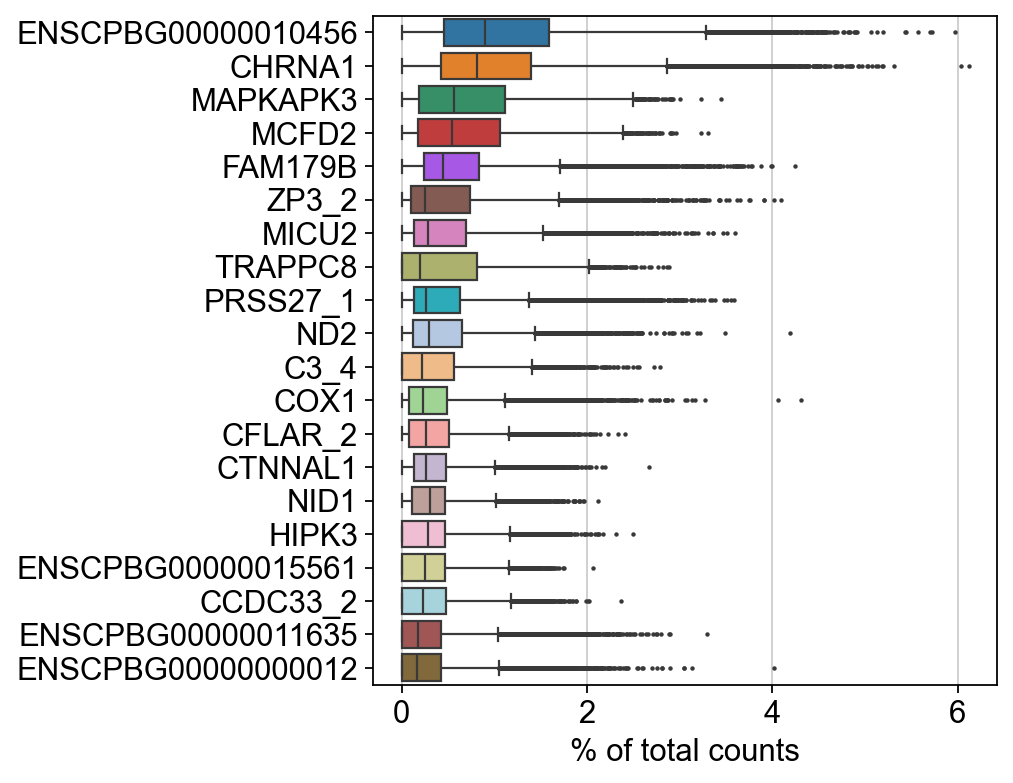

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [15]:
sc.pp.filter_cells(adata, min_genes=100) 
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape) 

adata

filtered out 24 cells that have less than 100 genes expressed
filtered out 8619 genes that are detected in less than 3 cells
(29421, 18199)


AnnData object with n_obs × n_vars = 29421 × 18199
    obs: 'n_genes_by_counts', 'total_counts', 'leiden', 'treatment', 'n_genes'
    var: 'gene_ids', 'n_cells_by_counts-control', 'mean_counts-control', 'pct_dropout_by_counts-control', 'total_counts-control', 'n_cells_by_counts-lf', 'mean_counts-lf', 'pct_dropout_by_counts-lf', 'total_counts-lf', 'n_cells_by_counts-lps', 'mean_counts-lps', 'pct_dropout_by_counts-lps', 'total_counts-lps', 'n_cells_by_counts-pic', 'mean_counts-pic', 'pct_dropout_by_counts-pic', 'total_counts-pic', 'n_cells'
    obsm: 'X_pca', 'X_umap'

### Mitochondrial QC and general measures

Check if genes are annotated as mt by running:
- GENES= list(adata.var.index[adata.var.index.str.startswith('mt-'.upper())])
- GENES

In case the genes are not annotated as 'MT-'' (Like in bats), run:

- dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2'...etc}
- adata.var.rename(dict_replace, inplace = True)

In [16]:
dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2','COX3':'MT-COX3','ND1':'MT-ND1-1','ND1':'MT-ND1-2','ND2':'MT-ND2',
                'ND3':'MT-ND3','ND4':'MT-ND4','ND5':'MT-ND5','ND6':'MT-ND6','ND4L-1':'MT-ND4L','ATP6':'MT-ATP6','ATP8':'MT-ATP8',
                'CYTB':'MT-CYTB'}
adata.var.rename(dict_replace, inplace=True)
# ONLY MT-ATP6, MT-ND1, MT-ND4L

In [17]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondrial genes

In [18]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

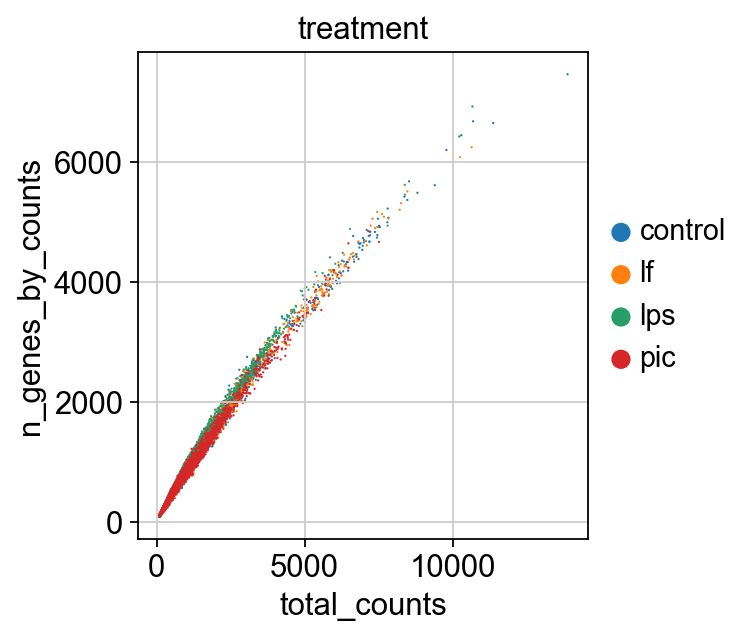

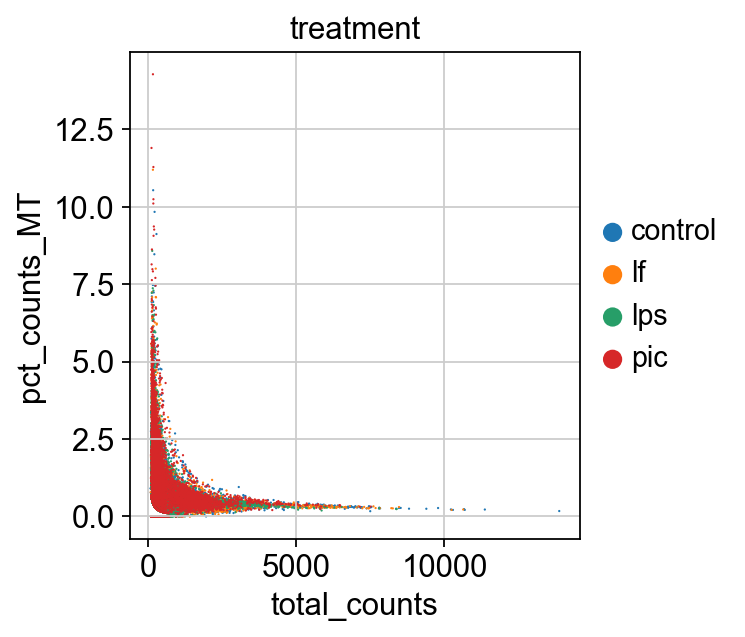

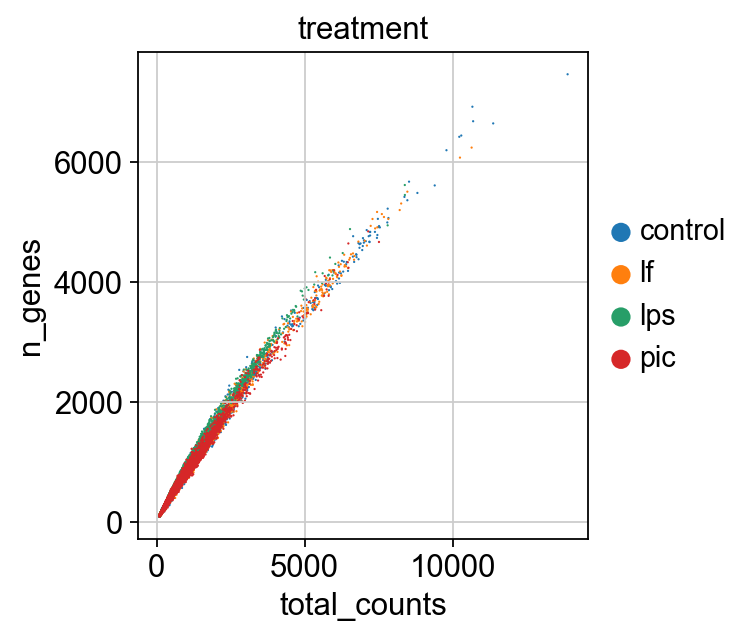

In [19]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='treatment')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT', color='treatment')
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='treatment', save=True)

In [20]:
adata = adata[adata.obs.pct_counts_MT < 20] 
adata = adata[adata.obs.total_counts < 5000, :] # If filtering outliers (<0.1% of cells)

adata

View of AnnData object with n_obs × n_vars = 29185 × 18199
    obs: 'n_genes_by_counts', 'total_counts', 'leiden', 'treatment', 'n_genes', 'total_counts_MT', 'pct_counts_MT'
    var: 'gene_ids', 'n_cells_by_counts-control', 'mean_counts-control', 'pct_dropout_by_counts-control', 'total_counts-control', 'n_cells_by_counts-lf', 'mean_counts-lf', 'pct_dropout_by_counts-lf', 'total_counts-lf', 'n_cells_by_counts-lps', 'mean_counts-lps', 'pct_dropout_by_counts-lps', 'total_counts-lps', 'n_cells_by_counts-pic', 'mean_counts-pic', 'pct_dropout_by_counts-pic', 'total_counts-pic', 'n_cells', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'treatment_colors'
    obsm: 'X_pca', 'X_umap'

In [21]:
import scrublet as scr

In [22]:
def scrub(adatas, adata, adata_names):
    print('Before scrublet: ', adata.shape[0])
    doub_index = []
    barcodes = []
    for data, name in zip(adatas, adata_names):
        data.raw = data
        sc.pp.normalize_total(data, target_sum=1e4)
        sc.pp.log1p(data)
        scrub = scr.Scrublet(data.raw.X)
        data.obs['doublet_scores'], data.obs['predicted_doublets'] = scrub.scrub_doublets()
        scrub.plot_histogram()
        print('Doublets' + name + ' :', data.obs[data.obs['doublet_scores'] > 0.25].shape[0])
        barcodes = data.obs[data.obs['doublet_scores'] < 0.25].index.to_list()
        for barcode in barcodes:
            doub_index.append(barcode + '-' + name)
            
    adata = adata[adata.obs.index.isin(doub_index)]
    print('After scrublet: ', adata.shape[0])
    return adata

Before scrublet:  29185
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 27.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.8%
Elapsed time: 6.1 seconds
Doubletscontrol : 290
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 5.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.9%
Elapsed time: 5.2 seconds
Doubletslf : 341
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.81
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 14.9 seconds
Doubletslps : 1087
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.73
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 5.5 seconds
Doubletspic : 281
After scrublet:  27196


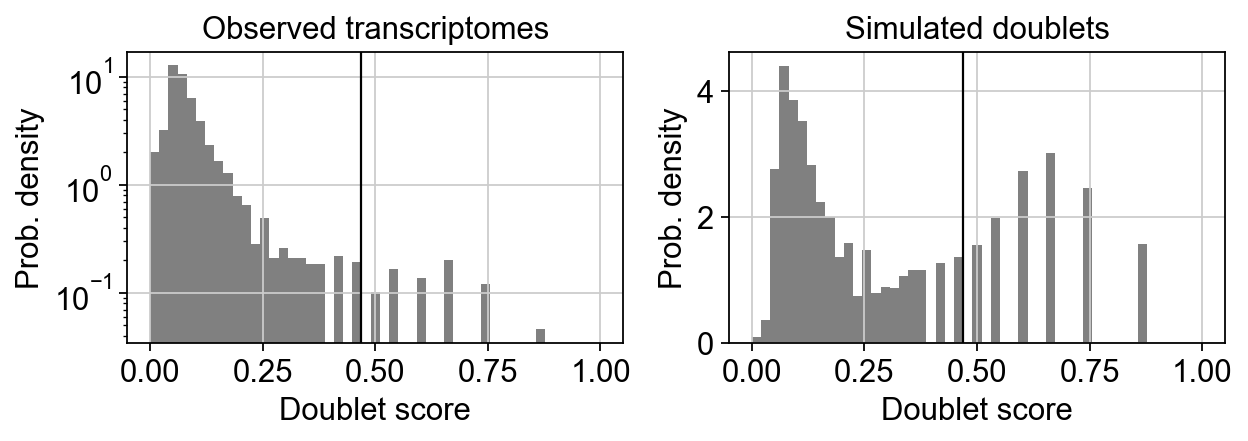

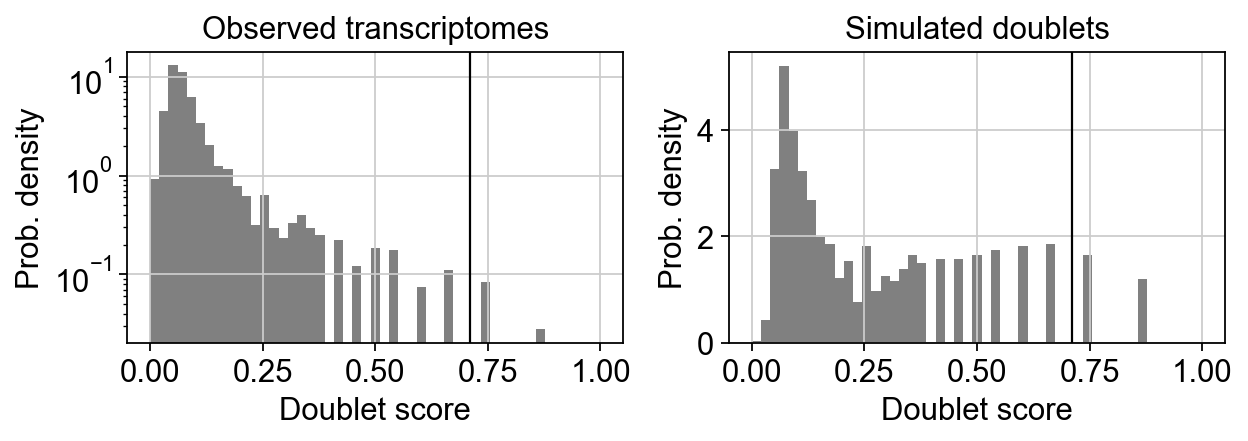

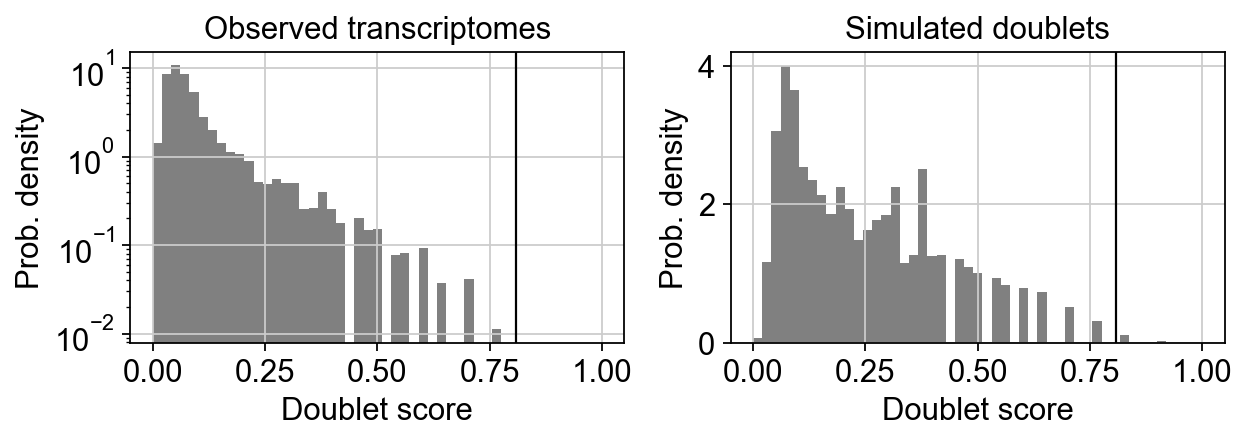

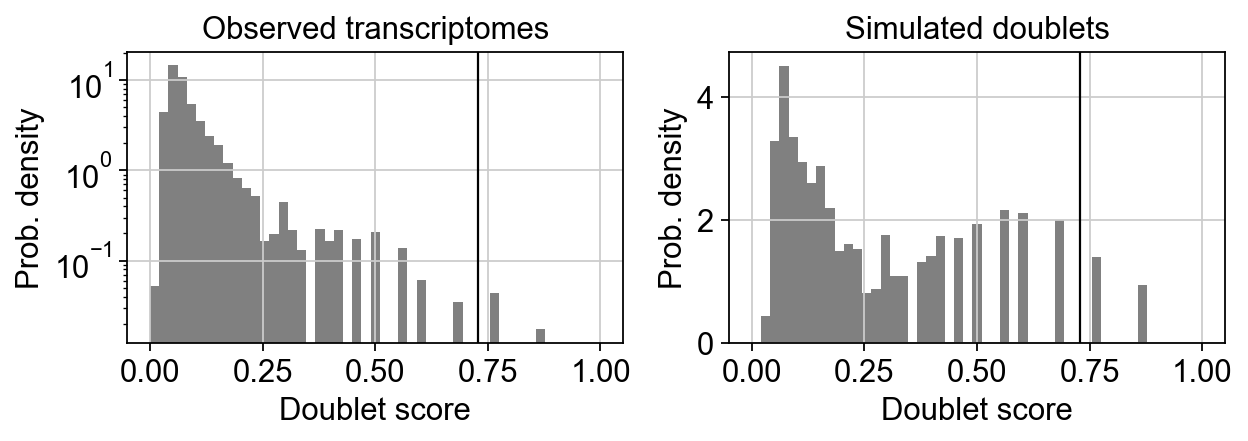

In [23]:
adata = scrub(adatas, adata, data_names)

### Cell cycle scoring

In [24]:
cell_cycle_genes = [x.strip() for x in open(r'/Code/data/single_cell/animals/turtle/turtle_3/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    449 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    500 total control genes are used. (0:00:02)
-->     'phase', cell cycle phase (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


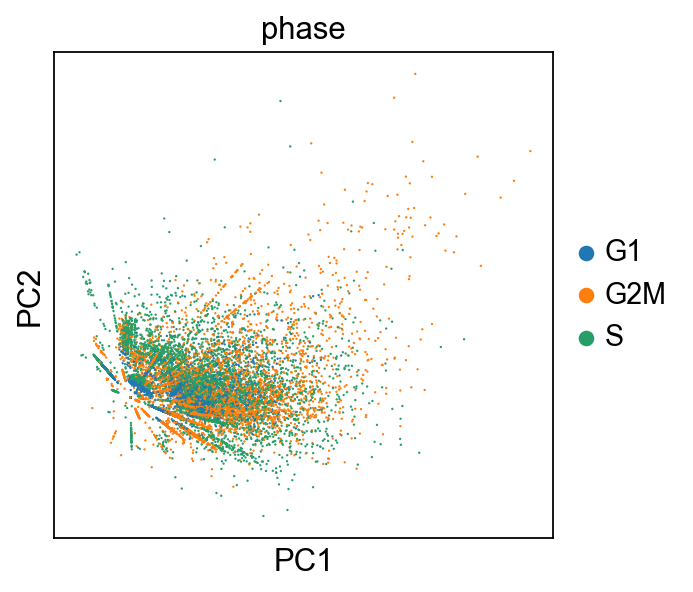

C:\Users\TzachiHNB2\AppData\Local\Temp\ipykernel_17172\1917813240.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()


In [25]:
cell_cycle_adata = adata.copy()

sc.pp.normalize_per_cell(cell_cycle_adata, counts_per_cell_after=1e4)
sc.pp.log1p(cell_cycle_adata)
sc.pp.scale(cell_cycle_adata)
sc.tl.score_genes_cell_cycle(cell_cycle_adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata_cc_genes = cell_cycle_adata[:, cell_cycle_genes].copy()
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase', save=True)
adata.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()
adata.obs['G2M_score'] = cell_cycle_adata.obs['G2M_score'].copy()
adata.obs['phase'] = cell_cycle_adata.obs['phase'].copy()